The basis of this project is to review if Covid-19 had an effect on the popularity of taxi in NYC. We take into consideration the year 2020 and 2018. We also take into consideration the months during the lockdown, April and May, and the months when NYC had less restriction, August and September. We compare them with the same months in 2018. 

First we create a 1D GMM and analyze the hour pickup time and see if it had any change in 2020. We also analyze if the location pickup was effected as well. 

Second we see how fare tip was effected post-Covid. We take in certain features in our dataset ( distance, fare, pickup time, and passenger count), and create a random forest regression to get a better accuracy. We compare the MSE and MAE for 2020 and 2018 and see what features played the most importance.


Conclusion: From our results we dont see any significant impact on pickup time or pickup location due to Covid-19. Our regressions also show that in a way, passenger count and hour time had a more important impact in tips in 2020 then 2018; but comparing our errors for both years they were fairly the same. Lastly we see that our R2 values were not reliable in 2020 as compared to 2018.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style='whitegrid')
import shapefile
import matplotlib as mpl
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
plt.style.use('ggplot')
%matplotlib inline

Lets first import the taxi data for the month of April and May 2020, when the shutdown of NYC occured, and also August and September of 2020, so we can compare it a little after NYC opened (with restrictions). We will also compare this with the same months from 2018.

In [3]:
data = pd.read_csv('yellow_tripdata_2020-04.csv')
yellow_4_2020 = pd.DataFrame(data)
data = pd.read_csv('yellow_tripdata_2020-05.csv')
yellow_5_2020 = pd.DataFrame(data)
data = pd.read_csv('yellow_tripdata_2020-08.csv')
yellow_8_2020 = pd.DataFrame(data)
data = pd.read_csv('yellow_tripdata_2020-09.csv')
yellow_9_2020 = pd.DataFrame(data)

/Users/eddy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
yellow_9_2020.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0,2020-09-01 00:38:58,2020-09-01 01:08:12,1.0,10.76,1.0,N,132,62,1.0,32.5,0.5,0.5,4.40,0.0,0.3,38.20,0.0
1,2.0,2020-09-01 00:55:26,2020-09-01 01:15:34,1.0,6.37,1.0,N,48,129,1.0,20.5,0.5,0.5,3.00,0.0,0.3,27.30,2.5
2,2.0,2020-09-01 00:00:40,2020-09-01 00:10:25,5.0,2.32,1.0,N,102,37,1.0,9.5,0.5,0.5,4.00,0.0,0.3,14.80,0.0
3,2.0,2020-09-01 00:26:01,2020-09-01 00:35:50,1.0,1.82,1.0,Y,137,246,1.0,8.5,0.5,0.5,3.08,0.0,0.3,15.38,2.5
4,1.0,2020-09-01 00:29:09,2020-09-01 01:00:33,1.0,4.90,1.0,N,79,170,1.0,24.0,3.0,0.5,1.00,0.0,0.3,28.80,2.5


In [4]:
data = pd.read_csv('yellow_tripdata_2018-04.csv')
yellow_4_2018 = pd.DataFrame(data)
data = pd.read_csv('yellow_tripdata_2018-05.csv')
yellow_5_2018 = pd.DataFrame(data)
data = pd.read_csv('yellow_tripdata_2018-08.csv')
yellow_8_2018 = pd.DataFrame(data)
data = pd.read_csv('yellow_tripdata_2018-09.csv')
yellow_9_2018 = pd.DataFrame(data)

In [5]:
yellow1 = pd.concat([yellow_4_2020, yellow_5_2020 ], ignore_index=True)
yellow2 = pd.concat([yellow_8_2020, yellow_9_2020 ], ignore_index=True)
yellow3 = pd.concat([yellow_4_2018, yellow_5_2018 ], ignore_index=True)
yellow4 = pd.concat([yellow_8_2018, yellow_9_2018 ], ignore_index=True)


Now lets extract our pickup time, we created a histogram with 24 bins, for 24 hours in the day.


In [7]:
PUT =  yellow1["tpep_pickup_datetime"].astype("datetime64")
PUT2 = yellow2["tpep_pickup_datetime"].astype("datetime64")
PUT3 = yellow3["tpep_pickup_datetime"].astype("datetime64")
PUT4 = yellow4["tpep_pickup_datetime"].astype("datetime64")

Text(0.5, 1.0, 'Hour Pickup August+September 2018')

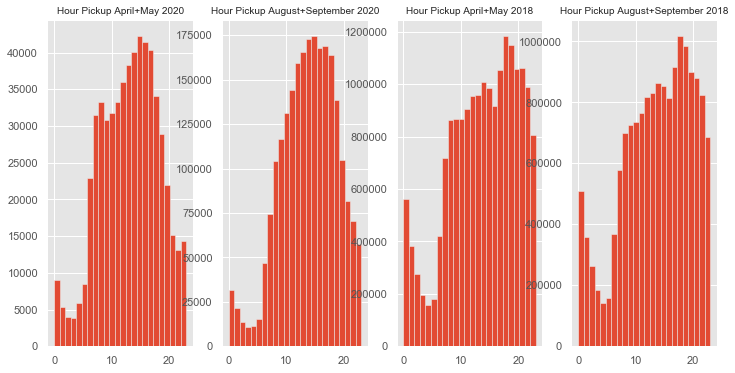

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].hist(PUT.dt.hour, bins=24);
ax[0].set_title('Hour Pickup April+May 2020', fontsize=10)
ax[1].hist(PUT2.dt.hour, bins=24);
ax[1].set_title('Hour Pickup August+September 2020', fontsize=10)
ax[2].hist(PUT3.dt.hour, bins=24);
ax[2].set_title('Hour Pickup April+May 2018', fontsize=10)
ax[3].hist(PUT4.dt.hour, bins=24);
ax[3].set_title('Hour Pickup August+September 2018', fontsize=10)

Right off the bat we can see some difference with 2020 vs 2018, rides after midnight are lower in 2020, make sense since bars and clubs are closed. Now lets try adding a gaussian mixture model, we set the mixtures to 2; so we can incorporate night vs day pickups.

In [7]:
from sklearn.mixture import GaussianMixture
GMM=GaussianMixture(2)
#GMM.fit(data) # fit the GMM model to data -> estimate the parameters 

In [8]:
GMM.fit(PUT.dt.hour.values.reshape(-1,1))
score=GMM.score_samples(np.linspace(0, 24, 586364).reshape(586364,1))
pdf = np.exp(score)
cluster_label=GMM.predict(PUT.dt.hour.values.reshape(-1,1))
GMM.fit(PUT2.dt.hour.values.reshape(-1,1))
score2=GMM.score_samples(np.linspace(0, 24, 2348296).reshape(2348296,1))
pdf2 = np.exp(score2)
cluster_label2=GMM.predict(PUT2.dt.hour.values.reshape(-1,1))
GMM.fit(PUT3.dt.hour.values.reshape(-1,1))
score3=GMM.score_samples(np.linspace(0, 24, 18529578).reshape(18529578,1))
pdf3 = np.exp(score3)
cluster_label3=GMM.predict(PUT3.dt.hour.values.reshape(-1,1))
GMM.fit(PUT4.dt.hour.values.reshape(-1,1))
score4=GMM.score_samples(np.linspace(0, 24, 15889267).reshape(15889267,1))
pdf4 = np.exp(score4)
cluster_label4=GMM.predict(PUT4.dt.hour.values.reshape(-1,1))

Text(0.5, 1.0, 'GMM pdf Aug+Sep 2018')

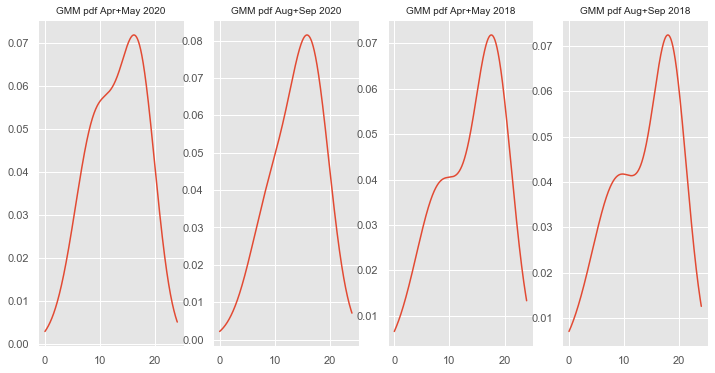

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].plot(np.linspace(0, 24, 586364), pdf)
ax[0].set_title('GMM pdf Apr+May 2020', fontsize=10)
ax[1].plot(np.linspace(0, 24, 2348296), pdf2)
ax[1].set_title('GMM pdf Aug+Sep 2020', fontsize=10)
ax[2].plot(np.linspace(0, 24, 18529578), pdf3)
ax[2].set_title('GMM pdf Apr+May 2018', fontsize=10)
ax[3].plot(np.linspace(0, 24, 15889267), pdf4)
ax[3].set_title('GMM pdf Aug+Sep 2018', fontsize=10)


Wow so we can see a clear distinction between 2020 and 2018, GMM had a more difficult time dividing the groups in 2020 rather than 2018. Now lets cluster the data

Text(0.5, 1.0, 'clustering result 4')

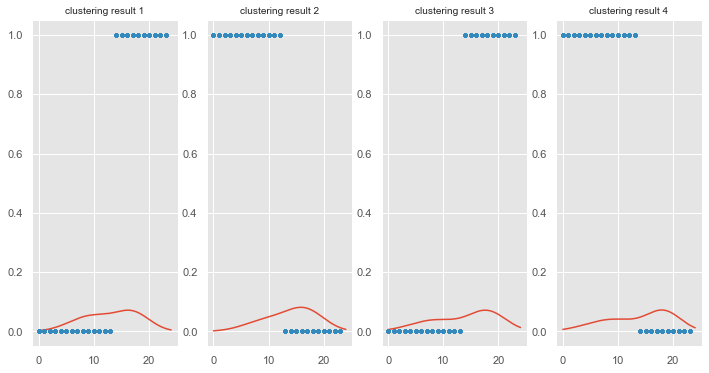

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].plot(np.linspace(0, 24, 586364), pdf)
ax[0].plot(PUT.dt.hour.values, cluster_label, '.')
ax[0].set_title('clustering result 1', fontsize=10)
ax[1].plot(np.linspace(0, 24, 2348296), pdf2)
ax[1].plot(PUT2.dt.hour.values, cluster_label2, '.')
ax[1].set_title('clustering result 2', fontsize=10)
ax[2].plot(np.linspace(0, 24, 18529578 ), pdf3)
ax[2].plot(PUT3.dt.hour.values, cluster_label3, '.')
ax[2].set_title('clustering result 3', fontsize=10)
ax[3].plot(np.linspace(0, 24, 15889267 ), pdf4)
ax[3].plot(PUT4.dt.hour.values, cluster_label4, '.')
ax[3].set_title('clustering result 4', fontsize=10)

After clustering the data points, we see that in 2020, its a little more split in the middle, while in 2018, the afternoon and night rush dominates pickups.


Next we will see if Covid-19 impacted location pickup. It is safe to assume that most pickup might happen in downtown manhattan, but with remote work, this might change. Lets analyze:


In [9]:
PUL =  yellow1["PULocationID"]
PUL2 = yellow2["PULocationID"]
PUL3 = yellow3["PULocationID"]
PUL4 = yellow4["PULocationID"]

Text(0.5, 1.0, 'Pickup Location August+September 2018')

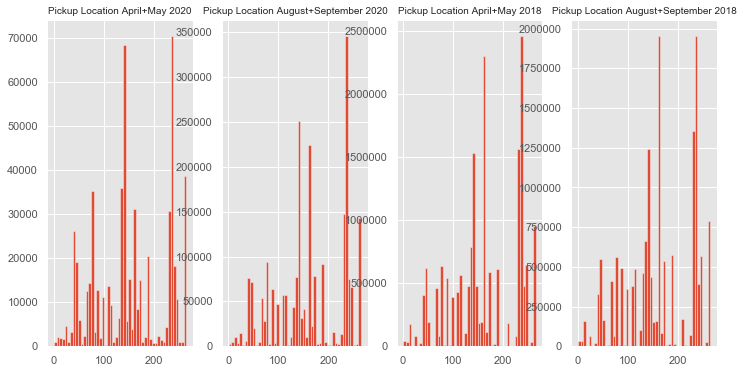

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].hist(PUL, bins=50);
ax[0].set_title('Pickup Location April+May 2020', fontsize=10)
ax[1].hist(PUL2, bins=50);
ax[1].set_title('Pickup Location August+September 2020', fontsize=10)
ax[2].hist(PUL3, bins=50);
ax[2].set_title('Pickup Location April+May 2018', fontsize=10)
ax[3].hist(PUL4, bins=50);
ax[3].set_title('Pickup  August+September 2018', fontsize=10)

Okay so in early 2020 we see a more diveresed distribution as compared to later 2020 and 2018, the bins in this case are location ID, which I have linked a map shown below, it seems that no matter what year, upper east side (around ID 260) is the most dense in pickups

In [11]:
sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]


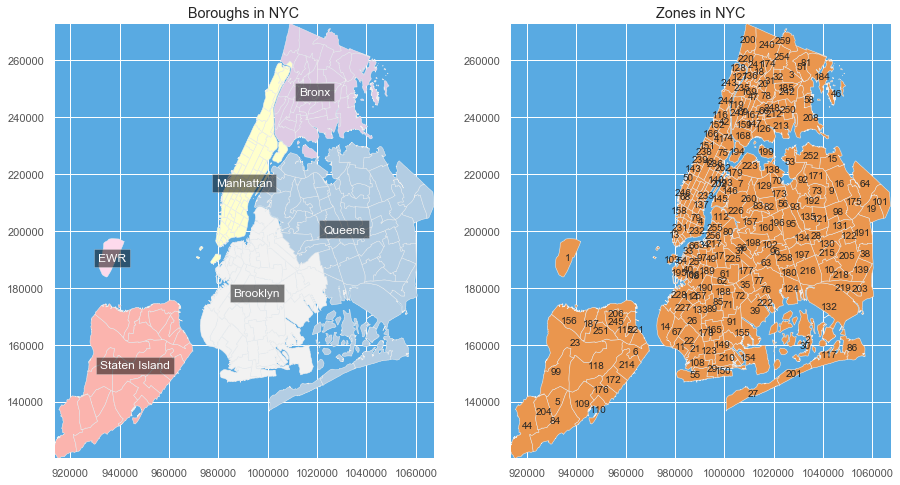

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)


Here is the map depicting location ID, this is not my code, I have linked the original source down below; EWR is in new jersey, newark airport. 



Now as before we will split the data into 2 Gaussians, and compare the results

In [13]:
from sklearn.mixture import GaussianMixture
GMM=GaussianMixture(2)


In [14]:
GMM.fit(PUL.values.reshape(-1,1))
score=GMM.score_samples(np.linspace(0, 263, 586364).reshape(586364,1))
pdf = np.exp(score)
cluster_label=GMM.predict(PUL.values.reshape(-1,1))
GMM.fit(PUL2.values.reshape(-1,1))
score2=GMM.score_samples(np.linspace(0, 263, 2348296).reshape(2348296,1))
pdf2 = np.exp(score2)
cluster_label2=GMM.predict(PUL2.values.reshape(-1,1))
GMM.fit(PUL3.values.reshape(-1,1))
score3=GMM.score_samples(np.linspace(0, 263, 18529578).reshape(18529578,1))
pdf3 = np.exp(score3)
cluster_label3=GMM.predict(PUL3.values.reshape(-1,1))
GMM.fit(PUL4.values.reshape(-1,1))
score4=GMM.score_samples(np.linspace(0, 263, 15889267).reshape(15889267,1))
pdf4 = np.exp(score4)
cluster_label4=GMM.predict(PUL4.values.reshape(-1,1))

Text(0.5, 1.0, 'GMM pdf Aug+Sep 2018')

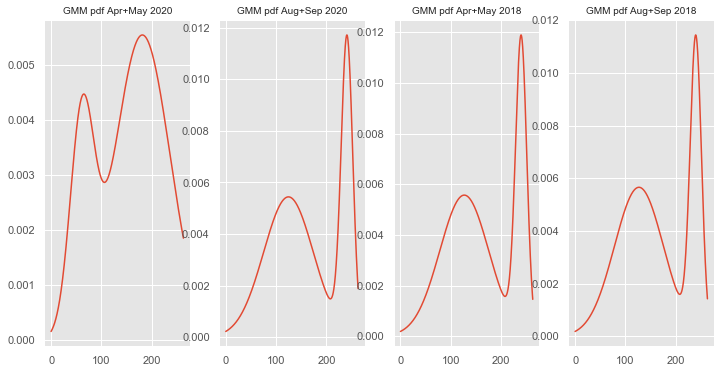

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].plot(np.linspace(0, 263, 586364), pdf)
ax[0].set_title('GMM pdf Apr+May 2020', fontsize=10)
ax[1].plot(np.linspace(0, 263, 2348296), pdf2)
ax[1].set_title('GMM pdf Aug+Sep 2020', fontsize=10)
ax[2].plot(np.linspace(0, 263, 18529578), pdf3)
ax[2].set_title('GMM pdf Apr+May 2018', fontsize=10)
ax[3].plot(np.linspace(0, 263, 15889267), pdf4)
ax[3].set_title('GMM pdf Aug+Sep 2018', fontsize=10)


As can see from the graph the lockdown created a higher gaussian distribution for the first mixture, so we can safely conclude that there was some more pickups around the 0-100 location ID, this includes some locations in the boroughs excluding manhattan, like queens and brooklyn. 

Not much has changed from late 2020 vs. 2018 so ultimatley covid did not really alter pickup location, as much as we suspected it would.


Lets do a cluster on the data as well:

Text(0.5, 1.0, 'clustering result')

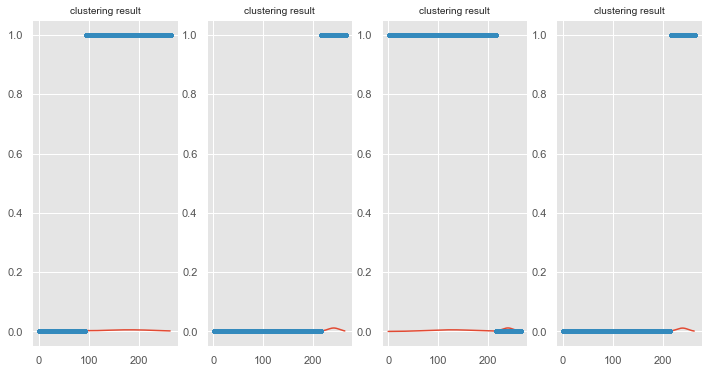

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].plot(np.linspace(0, 263, 586364), pdf)
ax[0].plot(PUL.values, cluster_label, '.')
ax[0].set_title('clustering result Apr+May 2020', fontsize=10)
ax[1].plot(np.linspace(0, 263, 2348296), pdf2)
ax[1].plot(PUL2.values, cluster_label2, '.')
ax[1].set_title('clustering result Aug+Sep 2020', fontsize=10)
ax[2].plot(np.linspace(0, 263, 18529578 ), pdf3)
ax[2].plot(PUL3.values, cluster_label3, '.')
ax[2].set_title('clustering result Apr+May 2018', fontsize=10)
ax[3].plot(np.linspace(0, 263, 15889267 ), pdf4)
ax[3].plot(PUL4.values, cluster_label4, '.')
ax[3].set_title('clustering result Aug+Sep 2018', fontsize=10)

Lets now see if tip value was changed at all due to the Pandemic; we will use random forest regression for better accuracy. The features we used are passenger count, trip distance, hour pickup and the fare amount.

We did not use LocationID since its a classification column and creating over 263 dummy variables may take a very long time for our tree.

In [8]:
X1=pd.DataFrame()
X1['passenger_count']=yellow1['passenger_count']
X1['trip_distance']=yellow1['trip_distance']
X1['time_hour']=PUT.dt.hour.values   
X1['fare_amount']=yellow1['fare_amount']
X1['tip_amount']=yellow1['tip_amount']

X1=X1. dropna(subset=['passenger_count', 'trip_distance','time_hour','fare_amount','tip_amount'])



X2=pd.DataFrame()
X2['passenger_count']=yellow2['passenger_count']
X2['trip_distance']=yellow2['trip_distance']
X2['time_hour']=PUT2.dt.hour.values
X2['fare_amount']=yellow2['fare_amount']
X2['tip_amount']=yellow2['tip_amount']
X2=X2. dropna(subset=['passenger_count', 'trip_distance','time_hour','fare_amount','tip_amount'])




X3=pd.DataFrame()
X3['passenger_count']=yellow3['passenger_count']
X3['trip_distance']=yellow3['trip_distance']
X3['time_hour']=PUT3.dt.hour.values
X3['fare_amount']=yellow3['fare_amount']
X3['tip_amount']=yellow3['tip_amount']
X3=X3. dropna(subset=['passenger_count', 'trip_distance','time_hour', 'fare_amount','tip_amount'])



X4=pd.DataFrame()
X4['passenger_count']=yellow4['passenger_count']
X4['trip_distance']=yellow4['trip_distance']
X4['time_hour']=PUT4.dt.hour.values
X4['fare_amount']=yellow4['fare_amount']
X4['tip_amount']=yellow4['tip_amount']
X4=X4. dropna(subset=['passenger_count', 'trip_distance','time_hour', 'fare_amount','tip_amount'])



Y1=X1['tip_amount']
Y2=X2['tip_amount']
Y3=X3['tip_amount']
Y4=X4['tip_amount']

X1=X1.drop(['tip_amount'], axis=1)
X2=X2.drop(['tip_amount'], axis=1)
X3=X3.drop(['tip_amount'], axis=1)
X4=X4.drop(['tip_amount'], axis=1)


#convert to numpy
X1_columns=X1.columns
X1=X1.values
Y1=Y1.values
X2_columns=X2.columns
X2=X2.values
Y2=Y2.values
X3_columns=X3.columns
X3=X3.values
Y3=Y3.values
X4_columns=X4.columns
X4=X4.values
Y4=Y4.values

Lets split the data into training and testing, and validation

In [9]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X1_train, Y1_train, test_size=0.1, random_state=0)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2_train, Y2_train, test_size=0.1, random_state=0)

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X3_train, X3_val, Y3_train, Y3_val = train_test_split(X3_train, Y3_train, test_size=0.1, random_state=0)

X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, Y4, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X4_train, X4_val, Y4_train, Y4_val = train_test_split(X4_train, Y4_train, test_size=0.1, random_state=0)


In [10]:
#Normalize the data

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X1_train) 
X1_train=scaler.transform(X1_train)
X1_val=scaler.transform(X1_val)
X1_test=scaler.transform(X1_test)

scaler=MinMaxScaler()
scaler.fit(X2_train)
X2_train=scaler.transform(X2_train)
X2_val=scaler.transform(X2_val)
X2_test=scaler.transform(X2_test)

scaler=MinMaxScaler()
scaler.fit(X3_train) 
X3_train=scaler.transform(X3_train)
X3_val=scaler.transform(X3_val)
X3_test=scaler.transform(X3_test)

scaler=MinMaxScaler()
scaler.fit(X4_train) 
X4_train=scaler.transform(X4_train)
X4_val=scaler.transform(X4_val)
X4_test=scaler.transform(X4_test)

Lets now create a random forest for regression, to get an accurate result on how these 3 features act on fare tip, and of course compare 2018 and 2020

In [11]:
from sklearn.ensemble import RandomForestRegressor
RF= RandomForestRegressor(n_estimators=20, max_depth=10)
RF.fit(X1_train,Y1_train)
Y1_train_pred = RF.predict(X1_train)
Y1_test_pred = RF.predict(X1_test)
score_test1=RF.score(X1_test, Y1_test)
features1=RF.feature_importances_

RF= RandomForestRegressor(n_estimators=20, max_depth=10)
RF.fit(X2_train,Y2_train)
Y2_train_pred = RF.predict(X2_train)
Y2_test_pred = RF.predict(X2_test) 
score_test2=RF.score(X2_test, Y2_test)
features2=RF.feature_importances_

RF= RandomForestRegressor(n_estimators=20, max_depth=10)
RF.fit(X3_train,Y3_train)
Y3_train_pred = RF.predict(X3_train)
Y3_test_pred = RF.predict(X3_test)
score_test3=RF.score(X3_test, Y3_test)
features3=RF.feature_importances_

RF= RandomForestRegressor(n_estimators=20, max_depth=10)
RF.fit(X4_train,Y4_train)
Y4_train_pred = RF.predict(X4_train)
Y4_test_pred = RF.predict(X4_test)
score_test4=RF.score(X4_test, Y4_test)
features4=RF.feature_importances_

Now lets check the MSE and MAE

In [12]:
#Cannot use MAPE since some values for tip are 0; no tip

print('Evaluate model on testing set; April and May 2020')
MSE = np.mean((Y1_test - Y1_test_pred)**2)
MAE = np.mean(np.abs(Y1_test - Y1_test_pred))
#MAPE =  np.mean(np.abs(Y1_test - Y1_test_pred)/Y1_test)
print('MSE=', MSE)
print('MAE=', MAE)
#print('MAPE=', MAPE)

print('')
print('Evaluate model on testing set; August and September 2020')
MSE = np.mean((Y2_test - Y2_test_pred)**2)
MAE = np.mean(np.abs(Y2_test - Y2_test_pred))
#MAPE =  np.mean(np.abs(Y2_test - Y2_test_pred)/Y2_test)
print('MSE=', MSE)
print('MAE=', MAE)
#print('MAPE=', MAPE)

print('')
print('Evaluate model on testing set; April and May 2018')
MSE = np.mean((Y3_test - Y3_test_pred)**2)
MAE = np.mean(np.abs(Y3_test - Y3_test_pred))
#MAPE =  np.mean(np.abs(Y3_test - Y3_test_pred)/Y3_test)
print('MSE=', MSE)
print('MAE=', MAE)
#print('MAPE=', MAPE)

print('')
print('Evaluate model on testing set; August and September 2018')
MSE = np.mean((Y4_test - Y4_test_pred)**2)
MAE = np.mean(np.abs(Y4_test - Y4_test_pred))
#MAPE =  np.mean(np.abs(Y4_test - Y4_test_pred)/Y4_test)
print('MSE=', MSE)
print('MAE=', MAE)
#print('MAPE=', MAPE)

Evaluate model on testing set; April and May 2020
MSE= 5.501324494109693
MAE= 1.4182604253114843

Evaluate model on testing set; August and September 2020
MSE= 4.209061255091303
MAE= 1.3628022286376966

Evaluate model on testing set; April and May 2018
MSE= 4.263325200317971
MAE= 1.3280762695279962

Evaluate model on testing set; August and September 2018
MSE= 4.570353130855889
MAE= 1.3549970037140873


Okay so the MSE and MAE for both the years are very similar so we can see the features we choose didnt change that much after Covid


Now lets see what features have the most impact

Text(0.5, 1.0, 'Feature importance Aug+Sep 2018')

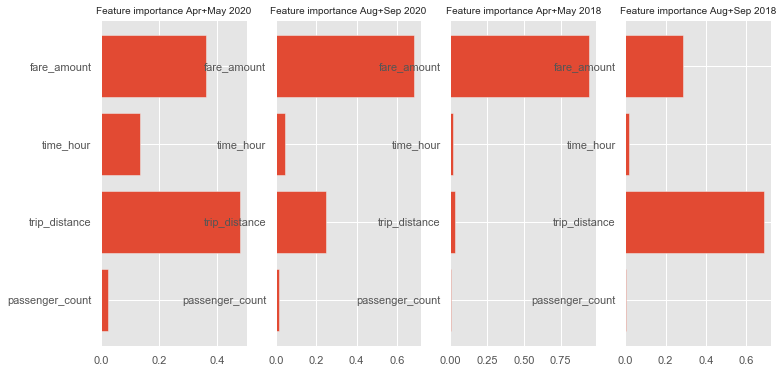

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
ax[0].barh(y=X1_columns, width=features1)
ax[0].set_title('Feature importance Apr+May 2020', fontsize=10)
ax[1].barh(y=X2_columns, width=features2)
ax[1].set_title('Feature importance Aug+Sep 2020', fontsize=10)
ax[2].barh(y=X3_columns, width=features3)
ax[2].set_title('Feature importance Apr+May 2018', fontsize=10)
ax[3].barh(y=X4_columns, width=features4)
ax[3].set_title('Feature importance Aug+Sep 2018', fontsize=10)

Okay so we definitly see trip_distance and fare amount had the most impact on the tip, second is the hour, and it s very interesting to see that in 2020 the hour pickup had more impact to tip then in 2018. We can cnlude hour pickup was effected by Covid. 


Lets see how well the features we choose fit the model:

In [14]:
print('R2 on testing set', score_test1)
print('R2 on testing set', score_test2)
print('R2 on testing set', score_test3)
print('R2 on testing set', score_test4)

R2 on testing set 0.10267485115509056
R2 on testing set 0.17729533695014044
R2 on testing set 0.3736535914155463
R2 on testing set 0.3341248930219096


Wow, the features didn't fit so well so we have to take the results of the data in 2020, the features dont do a good job explaining the variation in tip. We must take it with a grain of salt. 

In [1]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [2]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [3]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

Credit to the map: https://chih-ling-hsu.github.io/2018/05/14/NYC

